# Parametrized test hyperparameters

## Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import warnings
import seaborn as sns
import pandas as pd
from matplotlib import gridspec
from collections import defaultdict
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

## initialise path to posteriors (individual/combined folders)
path_to_posteriors='../'
sys.path.append('../../')
import utils

sns.set(style='ticks', context='notebook', font='times-new-roman', 
        font_scale=2.5, palette='colorblind')
plt.rcParams.update(utils.rcParams)

# further tune some rcParams
plt.rcParams.update({
    'legend.fontsize': 1.2*utils.fs,
})

numpy.random.seed(1234)

In [3]:
from par_plotter import *

## Settings

In [4]:
approxs = ['seob']
cache_path = os.path.join(path_to_posteriors,'combined/posterior_{kind}_{approx}_{param}.dat.gz')

# rescale -1PN coefficient for ease of display
rescale_minus2 = 200

In [5]:
params_pre = ['dphi-2']+ ['dphi%i' % n for n in range(5)] +\
             ['dphi5l', 'dphi6', 'dphi6l', 'dphi7']

params = params_pre

In [6]:
len(params)

10

## Load data

In [7]:
# path to hierarchical hyperparameter results
cache_path = os.path.join(path_to_posteriors,'hyperparams/hyper_{approx}_{par}_{hyper}.dat.gz')

hyper_dict = {}
for a in approxs:
    draws = {}
    for k in ['mu', 'sigma']:
        draws[k] = {}
        for p in params:
            path = cache_path.format(par=p, hyper=k, approx=a)
            if os.path.exists(path):
                draws[k][p] = np.loadtxt(path)
    hyper_dict[a] = draws

## Contour plot

First, compute the GR z-score based on the samples from the hierarchical analysis.

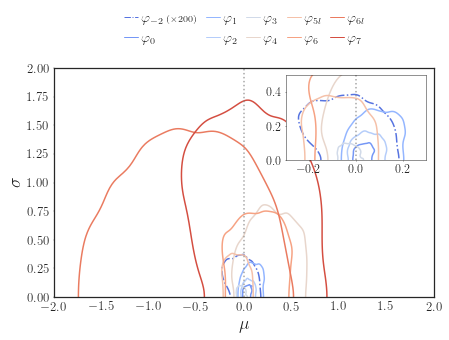

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(utils.fig_width, utils.fig_height),
                        gridspec_kw={'hspace': 0.1})

lines = {}
for a in approxs:
    axins = axs.inset_axes([0.61, 0.6, 0.37, 0.37])
    # get parameter names for this approximant
    ps = params if a[0]=='p' else params_pre
    for i, p in enumerate(ps):
        # reflect samples around sigma=0 line to help 2D KDE at the edge,
        # and downsample for speed
        idxs = np.random.choice(range(len(hyper_dict[a]['mu'][p])),
                                2000, replace=False)
        scale = rescale_minus2 if '-2' in p else 1
        x = scale*hyper_dict[a]['mu'][p][idxs]
        y = scale*hyper_dict[a]['sigma'][p][idxs]
        pts = np.row_stack((x, y))
        pts_reflected = np.column_stack((pts, np.row_stack((x, -y))))
        # set color and linestyle
        c = sns.color_palette('coolwarm', n_colors=len(params))[i]
        ls = '-' if 'phi' in p else '--'
        if '-2' in p:
            ls = '-.'
        # plot 90% contour
        for ax_i in [axs, axins]:
            utils.kdeplot_2d_clevels(pts_reflected[0], pts_reflected[1], 
                                     levels=[0.9], colors=(c,), cmap=None,
                                     linestyles=(ls,), ax=ax_i)
        # store line to make custom legend below
        lines[p], = axs.plot([], [], c=c, ls=ls,linewidth=1.)
   
    # format main axes
    axs.set_xlim(-2, 2);
    axs.set_ylim(0, 2);
    axs.set_ylabel(r'$\sigma$')
     # format inset
    axins.set_xlim(-0.3, 0.3);
    axins.set_ylim(0, 0.5);
    axins.axvline(0, ls=':', c='gray', alpha=0.7)
    axins.tick_params(labelsize=0.85*utils.fs_label, width=0.5, length=1)
    axins.set_yticks([0, 0.2, 0.4])
    [i.set_linewidth(0.5) for i in axins.spines.values()]
    # add vertical line at GR value
    axs.axvline(0, ls=':', c='gray', alpha=0.7)
       
# final touches on main axes
#axs.set_xticklabels([])
axs.set_xlabel(r'$\mu$')
axs.tick_params(labelsize=0.9*utils.fs_label, width=0.25, length=1)

# construct custom legend 
lkws = dict(columnspacing=0.7, handlelength=1, handletextpad=0.2, 
            loc='lower center', frameon=False)

pre_len=len(params_pre)

labels = [get_label(p) for p in params[:pre_len]]
labels[0] += r'$\, {\scriptstyle (\times %s)}$'%str(rescale_minus2)
axs.legend([lines[p] for p in params], labels, ncol=5,
              bbox_to_anchor=(0.5, 1.05), **lkws,fontsize=14)

fig.savefig('./par_hier_contour.pdf', bbox_inches='tight')